In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
IMAGE_DIR = "/content/drive/MyDrive/Placenta_only_dataset"

files = os.listdir(IMAGE_DIR)
images = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print("Total placenta images:", len(images))
print("Sample images:", images[:5])


Total placenta images: 4213
Sample images: ['Patient01513_Plane1_1_of_14.png', 'Patient00031_Plane1_11_of_42.png', 'Patient01424_Plane1_7_of_14.png', 'Patient01215_Plane1_8_of_24.png', 'Patient00848_Plane1_1_of_1.png']


In [5]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor()
])

print("SimCLR augmentations ready")


SimCLR augmentations ready


In [6]:
class SimCLRDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_dir = image_dir
        self.images = [f for f in os.listdir(image_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        return self.transform(image), self.transform(image)


In [7]:
dataset = SimCLRDataset(IMAGE_DIR, simclr_transform)
print("Dataset size:", len(dataset))

loader = DataLoader(
    dataset,
    batch_size=16,      # safe for Colab
    shuffle=True,
    drop_last=True
)

print("DataLoader ready")


Dataset size: 4213
DataLoader ready


In [8]:
class SimCLR(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z


In [9]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    similarity = torch.matmul(z1, z2.T)
    labels = torch.arange(z1.size(0)).to(z1.device)

    return F.cross_entropy(similarity / temperature, labels)


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = SimCLR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [11]:
EPOCHS = 5   # increase later if needed

for epoch in range(EPOCHS):
    total_loss = 0

    for x1, x2 in loader:
        x1, x2 = x1.to(device), x2.to(device)

        z1 = model(x1)
        z2 = model(x2)

        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(loader):.4f}")


Epoch 1/5 | Loss: 1.6932
Epoch 2/5 | Loss: 1.5045
Epoch 3/5 | Loss: 1.4561
Epoch 4/5 | Loss: 1.4229
Epoch 5/5 | Loss: 1.4029


In [12]:
model.eval()
for param in model.parameters():
    param.requires_grad = False

print("Model frozen for feature extraction")


Model frozen for feature extraction


In [13]:
import numpy as np

features = []
image_names = []

with torch.no_grad():
    for x1, x2 in loader:
        x1 = x1.to(device)
        h = model.encoder(x1)   # use encoder only
        features.append(h.cpu().numpy())

# Combine all batches
features = np.vstack(features)

print("Feature shape:", features.shape)


Feature shape: (4208, 512)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Features normalized")


Features normalized


In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

print("Clustering completed")


Clustering completed


In [16]:
import collections

cluster_counts = collections.Counter(cluster_labels)
print("Cluster distribution:", cluster_counts)


Cluster distribution: Counter({np.int32(3): 1394, np.int32(0): 1092, np.int32(1): 1083, np.int32(2): 639})


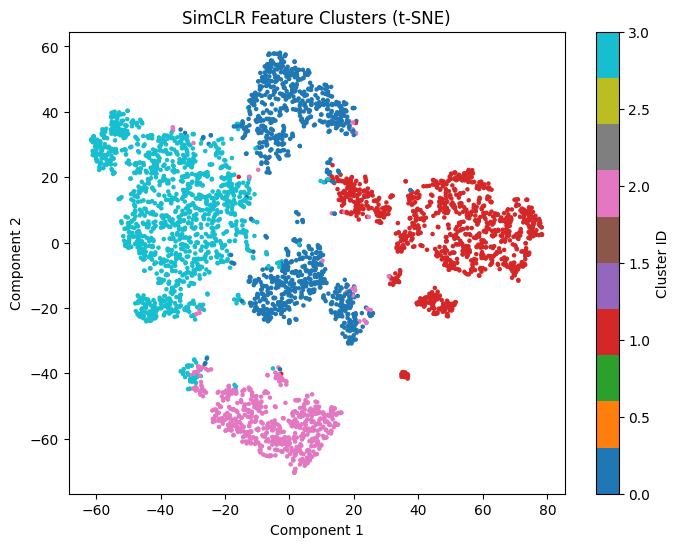

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
plt.scatter(features_2d[:,0], features_2d[:,1], c=cluster_labels, cmap='tab10', s=5)
plt.title("SimCLR Feature Clusters (t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster ID")
plt.show()


In [18]:
import cv2
import numpy as np

brightness_scores = {i: [] for i in range(4)}
texture_scores = {i: [] for i in range(4)}

image_files = images[:len(cluster_labels)]  # align counts

for img_name, cluster in zip(image_files, cluster_labels):
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        continue

    brightness = np.mean(img)
    texture = np.mean(cv2.Laplacian(img, cv2.CV_64F)**2)

    brightness_scores[cluster].append(brightness)
    texture_scores[cluster].append(texture)

for c in range(4):
    print(f"Cluster {c}:")
    print("  Avg Brightness:", np.mean(brightness_scores[c]))
    print("  Avg Texture:", np.mean(texture_scores[c]))


Cluster 0:
  Avg Brightness: 44.4640863981667
  Avg Texture: 1056.9792987091282
Cluster 1:
  Avg Brightness: 44.546175050706864
  Avg Texture: 1081.8134969991377
Cluster 2:
  Avg Brightness: 43.48857455363308
  Avg Texture: 1054.1191460878072
Cluster 3:
  Avg Brightness: 44.70343958585389
  Avg Texture: 1058.71343715746


In [19]:
cluster_to_grade = {
    0: 0,
    1: 1,
    2: 2,
    3: 3
}

grades = [cluster_to_grade[c] for c in cluster_labels]
print("Grade assignment complete")


Grade assignment complete


In [20]:
import pandas as pd

df = pd.DataFrame({
    "image_name": image_files,
    "cluster_id": cluster_labels,
    "placenta_grade": grades
})

csv_path = "/content/drive/MyDrive/Placenta_Grades_PseudoLabels.csv"
df.to_csv(csv_path, index=False)

print("Saved CSV to:", csv_path)


Saved CSV to: /content/drive/MyDrive/Placenta_Grades_PseudoLabels.csv


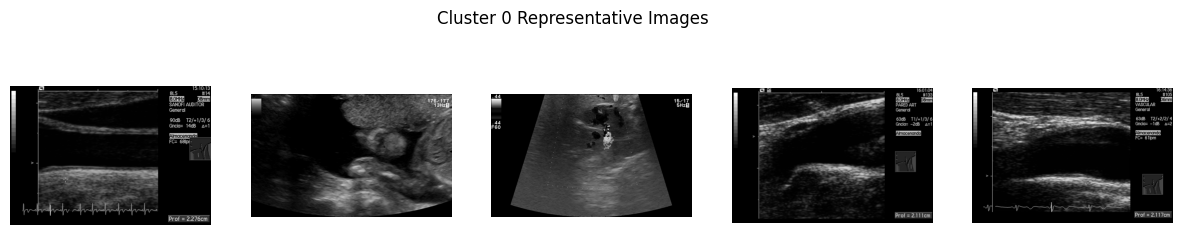

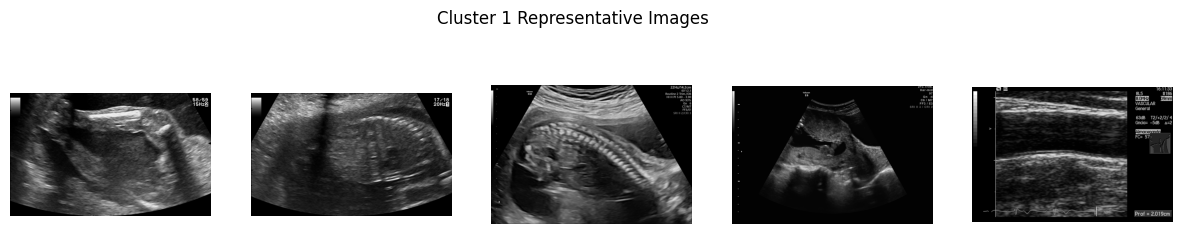

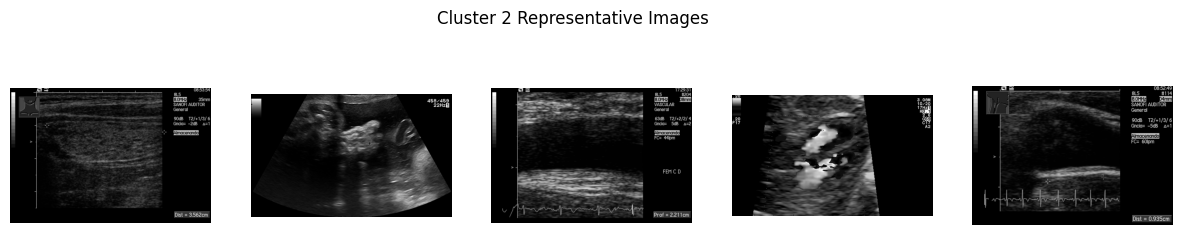

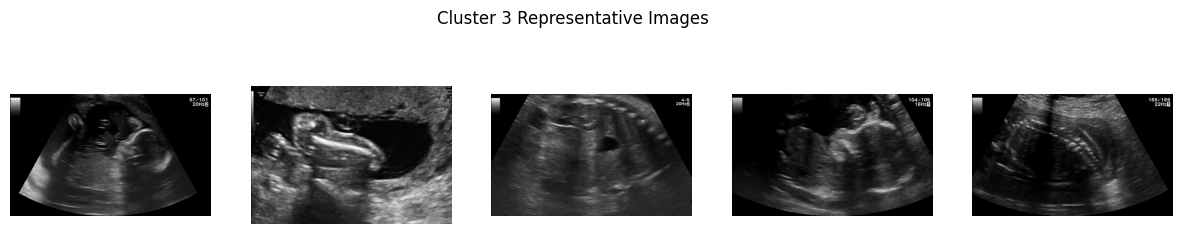

In [21]:
import matplotlib.pyplot as plt

def show_cluster_examples(cluster_id, n=5):
    idxs = [i for i, c in enumerate(cluster_labels) if c == cluster_id][:n]

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(idxs):
        img = Image.open(os.path.join(IMAGE_DIR, image_files[idx])).convert("RGB")
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id} Representative Images")
    plt.show()

for c in range(4):
    show_cluster_examples(c)
